In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"         # Disable GPU use
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"          # Suppress TensorFlow logs

import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np
import IPython.display as display

In [6]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [7]:
# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [8]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [16]:
cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture('novak.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    
    # Resize image
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
    
    cv2.imshow('Movenet Multipose', frame)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [17]:
results['output_0'].numpy()[:,:,:5]

array([[[0.77461404, 0.17030242, 0.33100703, 0.77023095, 0.17013177],
        [0.49058205, 0.49719787, 0.6741712 , 0.42757934, 0.5359921 ],
        [0.49058205, 0.49719787, 0.6741712 , 0.42757934, 0.5359921 ],
        [0.6101911 , 0.54766524, 0.00136794, 0.5534643 , 0.5770995 ],
        [0.49058205, 0.49719787, 0.6741712 , 0.42757934, 0.5359921 ],
        [0.0224707 , 0.8847724 , 0.07421444, 0.02242978, 0.8853535 ]]],
      dtype=float32)

In [18]:
keypoints_with_scores[0]

array([[0.77461404, 0.17030242, 0.33100703],
       [0.77023095, 0.17013177, 0.3460606 ],
       [0.770839  , 0.16912208, 0.29810092],
       [0.7695414 , 0.1708977 , 0.36576906],
       [0.77042884, 0.16861048, 0.32345584],
       [0.7929481 , 0.17456934, 0.31170917],
       [0.7946763 , 0.16678517, 0.37481585],
       [0.8225024 , 0.18629444, 0.19058755],
       [0.82835746, 0.17189884, 0.1891792 ],
       [0.8296957 , 0.1766377 , 0.14520071],
       [0.8333616 , 0.18258372, 0.18935563],
       [0.8437738 , 0.17708796, 0.13937466],
       [0.8454393 , 0.16929884, 0.16182078],
       [0.84692615, 0.18703936, 0.1389477 ],
       [0.85339606, 0.18690948, 0.10577681],
       [0.8467655 , 0.1697398 , 0.09612934],
       [0.8453628 , 0.16912358, 0.11004538]], dtype=float32)

In [19]:
frame

array([[[173, 199, 197],
        [172, 198, 196],
        [176, 197, 196],
        ...,
        [255, 252, 237],
        [255, 248, 236],
        [255, 249, 237]],

       [[173, 199, 197],
        [173, 199, 197],
        [175, 193, 201],
        ...,
        [255, 250, 238],
        [255, 249, 236],
        [255, 247, 235]],

       [[173, 197, 200],
        [173, 197, 200],
        [177, 197, 200],
        ...,
        [255, 248, 236],
        [255, 248, 240],
        [255, 244, 237]],

       ...,

       [[ 93,  93,  93],
        [ 90,  90,  90],
        [123, 128, 127],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[ 97,  98,  93],
        [ 92,  94,  89],
        [132, 137, 136],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[ 98,  99,  95],
        [ 93,  95,  90],
        [135, 145, 143],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]

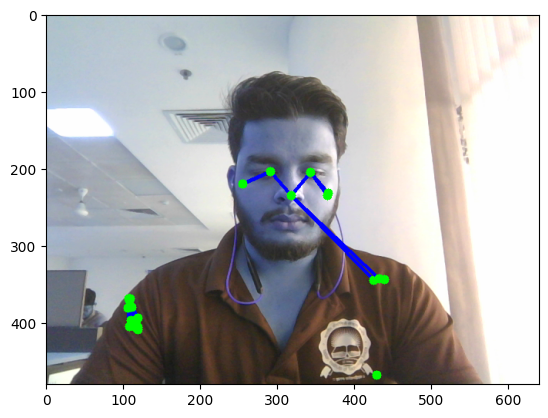

In [20]:
plt.imshow(frame)

In [21]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0,255,0), -1)

In [22]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 4)